In [ ]:
import tensorflow as tf
tf.__version__


'2.15.0'

In [ ]:
!pip install imutils --quiet

In [ ]:
from imutils.object_detection import non_max_suppression
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import os

In [ ]:
!git clone https://github.com/dilhelh/opencv-text-detection.git

fatal: destination path 'opencv-text-detection' already exists and is not an empty directory.


In [ ]:
!python opencv-text-detection/text_detection.py \
    --image opencv-text-detection/images/lebron_james.jpg \
    --east opencv-text-detection/frozen_east_text_detection.pb


[INFO] loading EAST text detector...
[INFO] text detection took 0.956533 seconds
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.10/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.



In [ ]:
!wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.11.0/coco_text_100.tar.gz
!tar xf coco_text_100.tar.gz

In [ ]:
IMAGE_LIST = list(paths.list_images('Mihinthale(24).jpg'))
IMG_SIZE = 320


In [ ]:
def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]

In [ ]:
quantization = "int8" # @param ["dr", "int8", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='opencv-text-detection/frozen_east_text_detection.pb',
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
open('east_model_{}.tflite'.format(quantization), 'wb').write(tflite_model)

96209448

In [ ]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

In [ ]:
!ls -lh *.tflite
!ls -lh opencv-text-detection/frozen_east_text_detection.pb

-rw-r--r-- 1 root root 92M Feb 18 19:00 east_model_int8.tflite
-rw-r--r-- 1 root root 93M Feb 18 18:34 opencv-text-detection/frozen_east_text_detection.pb


In [ ]:
def preprocess_image(image_path):
    # load the input image and grab the image dimensions
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)

    return image, orig, rW, rH

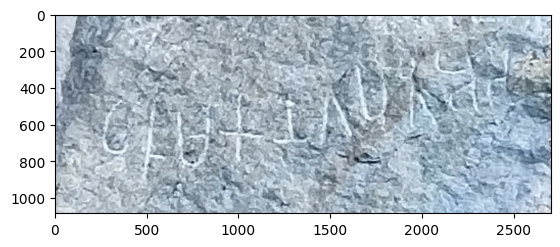

In [ ]:
image, orig, rW, rH = preprocess_image("Mihinthale(24).jpg")

# show the input image
plt.imshow(orig)

In [ ]:
def perform_inference(tflite_path, preprocessed_image):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    input_details = interpreter.get_input_details()

    if input_details[0]["dtype"]==np.uint8:
        print("Integer quantization!")
        input_scale, input_zero_point = input_details[0]["quantization"]
        preprocessed_image = preprocessed_image / input_scale + input_zero_point
    preprocessed_image = preprocessed_image.astype(input_details[0]["dtype"])
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    start = time.time()
    interpreter.invoke()
    print(f"Inference took: {time.time()-start} seconds")

    scores = interpreter.tensor(
        interpreter.get_output_details()[0]['index'])()
    geometry = interpreter.tensor(
        interpreter.get_output_details()[1]['index'])()

    return scores, geometry

In [ ]:
quantization = "int8" #@param ["dr", "int8", "float16"]
scores, geometry = perform_inference(tflite_path=f'east_model_{quantization}.tflite',
                                     preprocessed_image=image)

Inference took: 1.0156371593475342 seconds


In [ ]:
scores.shape, geometry.shape

((1, 80, 80, 1), (1, 80, 80, 5))

In [ ]:
scores = np.transpose(scores, (0, 3, 1, 2))
geometry = np.transpose(geometry, (0, 3, 1, 2))
scores.shape, geometry.shape

((1, 1, 80, 80), (1, 5, 80, 80))

In [ ]:
def post_process(score, geo, ratioW, ratioH, original):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = score.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = score[0, 0, y]
        xData0 = geo[0, 0, y]
        xData1 = geo[0, 1, y]
        xData2 = geo[0, 2, y]
        xData3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * ratioW)
        startY = int(startY * ratioH)
        endX = int(endX * ratioW)
        endY = int(endY * ratioH)

        # draw the bounding box on the image
        cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the output image
    plt.imshow(original)

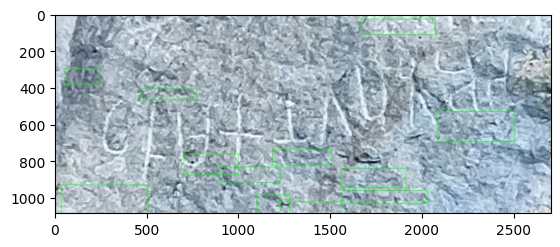

In [ ]:
original = cv2.imread("Mihinthale(24).jpg")
post_process(scores, geometry, rW, rH, original)

In [ ]:
pip install opencv-python numpy matplotlib tensorflow


In [ ]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (640, 640))  # You can adjust the size as needed
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load the EAST model
east_model_path = 'path/to/east_model.pb'  # Replace with the path to your EAST model file
east_model = tf.keras.models.load_model(east_model_path)

# Function to apply EAST text detection on an image
def apply_east_text_detection(image):
    input_image = np.expand_dims(image, axis=0)
    output = east_model.predict(input_image)
    scores, geometry = output[:, :, :, :1], output[:, :, :, 1:]
    return scores, geometry

# Function to decode EAST output and get bounding boxes
def decode_east_output(scores, geometry, score_threshold=0.5):
    detections = []
    _, _, _, cols = geometry.shape
    for i in range(cols):
        score = scores[0, 0, i, 0]
        if score > score_threshold:
            x, y = geometry[0, 0, i, 1:3]
            w, h = geometry[0, 0, i, 3:5]
            angle = geometry[0, 0, i, 0]
            detections.append((x, y, w, h, angle, score))
    return detections

# Function to draw bounding boxes on the image
def draw_bounding_boxes(image, detections):
    for detection in detections:
        x, y, w, h, angle, score = detection
        box = cv2.boxPoints(((x, y), (w, h), angle))
        box = np.int0(box)
        cv2.drawContours(image, [box], 0, (0, 255, 0), 2)
    return image

# Path to your dataset images
dataset_path = 'path/to/dataset'  # Replace with the path to your dataset folder

# Loop through each image in the dataset
for image_name in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, image_name)

    # Load and preprocess image
    image = load_and_preprocess_image(image_path)

    # Apply EAST text detection
    scores, geometry = apply_east_text_detection(image)

    # Decode output and get bounding boxes
    detections = decode_east_output(scores, geometry)

    # Draw bounding boxes on the original image
    result_image = draw_bounding_boxes(image.copy(), detections)

    # Display the result
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()


OSError: No file or directory found at path/to/east_model.pb